<a href="https://colab.research.google.com/github/YinYinTan/CIND820FinalProject/blob/main/4_Random_Forest_Classification_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification Models

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import time

In [ ]:
#Read file
df = pd.read_csv('3a. Working Dataset.csv', index_col=None)

# 1. All Features in Working Dataset - Evaluation using Train-Test Split

In [ ]:
#Split dataframe, using 80% for training and 20% for testing
from sklearn.model_selection import train_test_split

X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

In [ ]:
#Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
smote = SMOTE(random_state = 888)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Random forest classification model

t1 = time.perf_counter() #time counter start

model = RandomForestClassifier(random_state=888)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

t2 = time.perf_counter() #time counter ends

#Save results into dictionary
rf_all_base = {'Accuracy':metrics.accuracy_score(y_test, y_pred), 'Precision':metrics.precision_score(y_test, y_pred),'Recall':metrics.recall_score(y_test, y_pred),\
          'F1-Score':metrics.f1_score(y_test, y_pred),'AUC':metrics.roc_auc_score(y_test, y_pred),'Brier Score':metrics.brier_score_loss(y_test, y_pred),'Execution Time (sec)':int(t2-t1)}

#Evaluation of random forest classification model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))
print('Execution time in seconds:', int(t2-t1))

Accuracy: 0.7517321016166282
Precision: 0.8331877729257642
Recall: 0.7996647108130763
F1-score: 0.8160821214713431
Area Under Curve (AUC): 0.7226523925122894
Brier Score: 0.24826789838337182
Execution time in seconds: 5


# 2. All Features in Working Dataset - Hyperparameter Tuning

### 2.1 Random Search with Cross Validation
In this section, a grid of hyperparameter ranges will be defined, and randomly sampled from the grid, where k-fold cross validation will be performed with each combination of values.

In [ ]:
from pprint import pprint

#Look at parameters currently used by the model
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 888,
 'verbose': 0,
 'warm_start': False}


The following set of hyperparameters will be adjusted to narrow down the best combination of parameters:
*   n_estimators = number of trees in the foreset
*   max_features = max number of features considered for splitting a node
*   max_depth = max number of levels in each decision tree
*   min_samples_split = min number of data points placed in a node before the node is split
*   min_samples_leaf = min number of data points allowed in a leaf node
*   bootstrap = method for sampling data points (with or without replacement)

In [ ]:
#Creation of a parameter grid to sample from during fitting. On each iteration, the algorithm will choose a different, random combination of parameter values.

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

# Number of features to consider at every split
max_features = [2, 4, 6, 8, 10]

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50],
 'max_features': [2, 4, 6, 8, 10],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000]}


In [ ]:
#Using the random grid to search for best parameters

#Create the base model to tune
model = RandomForestClassifier(random_state=888)

#Random search of parameters across 100 different combinations, using 3 fold cross validation
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, scoring = 'recall', verbose=2, random_state=42, n_jobs = -1)

#Fit the random search model
model_random.fit(X_train, y_train)

#View the best parameters from fitting the random search (based on model with the best recall)
model_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 555}

In [ ]:
#Evaluation of best model from random search
best = model_random.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.7560623556581986
Precision: 0.8255175327418673
Recall: 0.8189438390611903
F1-score: 0.8222175468125394
Area Under Curve (AUC): 0.7179134779721535
Brier Score: 0.24393764434180137


Compared to the default random forest parameters used in the prior "All Features in Working Dataset - Evaluation using Train-Test Split" section, the best model from the grid search only resulted in a 1.9% increase in Recall (the metric chosen for scoring).
*   Accuracy, F1-score, and Brier Score improved very slightly.
*   Accuracy increased by 0.4%, the F1-score increased by 0.6%, and the Brier Score decreased by 0.4%.
*   Precision and AUC decreased very slightly by 0.8% and 0.5%, respectively.

The best model found in the random search has the same values for 1 of the 6 parameters as the default model (i.e. min_samples_leaf = 1).

### 2.2 Grid Search with Cross Validation
The random search above narrowed down the range for each hyperparameter. In this section, every combination of settings is defined.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Create the parameter grid based on the results of previous random search. This will try out 1 * 3 * 3 * 2 * 3 * 3 = 162 combinations of settings.
param_grid = {
    'bootstrap': [False],
    'max_depth': [25, 30, 35],
    'max_features': [7, 8, 9],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [500, 550, 600]
}

#Create the base model to tune
model = RandomForestClassifier(random_state=888)

#Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 3, scoring = 'recall', n_jobs = -1, verbose = 2)

#Fit the grid search model
grid_search.fit(X_train, y_train)

#View the best parameters from fitting the grid search (based on model with the best recall)
grid_search.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 550}

In [ ]:
#Evaluate performance of best model from grid search
best = grid_search.best_estimator_
y_pred=best.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-score:", metrics.f1_score(y_test, y_pred))
print("Area Under Curve (AUC):", metrics.roc_auc_score(y_test, y_pred))
print("Brier Score:", metrics.brier_score_loss(y_test, y_pred))

Accuracy: 0.7592378752886836
Precision: 0.8268744734625105
Recall: 0.8227158424140821
F1-score: 0.8247899159663865
Area Under Curve (AUC): 0.7207271234333863
Brier Score: 0.2407621247113164


Compared to the default random forest parameters used in the prior "All Features in Working Dataset - Evaluation using Train-Test Split" section, the best model from the random search only resulted in a 2.3% increase in Recall (the metric chosen for scoring).
*   Accuracy, F1-score, and Brier Score improved slightly.
*   Accuracy increased by 0.9%, the F1-score increased by 0.9%, and the Brier Score decreased by 0.8%.
*   Precision and AUC decreased very slightly by 0.6% and 0.2%, respectively.

The best model found in the grid search has the same value for 1 of the 6 parameters as the default model (i.e. min_samples_leaf = 1).

# 3. All Features in Working Dataset, Using Parameters from Grid Search - Evaluation using Repeated 10-fold Cross Validation

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#Random forest classification model
model = RandomForestClassifier(bootstrap='False', max_depth=30, max_features=7, min_samples_leaf=1, min_samples_split=5, n_estimators=550, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_all_tuned = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.7569332428758021
Precision: 0.8283452469587776
Recall: 0.8163572789444765
F1-score: 0.8222505685914855
Area Under Curve (AUC): 0.7208873593238152
Brier Score: 0.24306675712419765
Execution time in seconds: 21.255816308700027


# 4A. Selected Features - Filter Method

## 4A.1 Top Features Ranked by Importance

In [ ]:
#Identify top features based on model above
feature_names = df.drop(['Worse_MH'],axis=1).columns

feature_imp = pd.Series(model.feature_importances_,index=feature_names).sort_values(ascending=False)

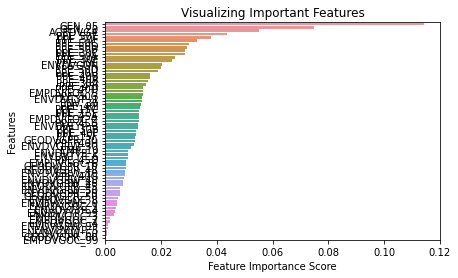

In [ ]:
#Plot features in terms of importance
import seaborn as sns

%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
feature_imp[:40].index

Index(['GEN_05', 'GEN_20', 'AGEDVG4', 'PPE_50E', 'PPE_50F', 'PPE_50C',
       'PPE_50D', 'PPE_50B', 'PPE_30C', 'PPE_50A', 'PPE_30F', 'PPE_30E',
       'ENVDVCON', 'PPE_30D', 'PPE_30H', 'PPE_40B', 'PPE_40A', 'PPE_30A',
       'PPE_45I', 'PPE_40D', 'EMPDVGOC_5', 'PPE_30G', 'ENVDVTYP_1', 'ENV_30',
       'PPE_40I', 'PPE_15C', 'PPE_15E', 'PPE_45A', 'EMPDVGOC_2', 'PPE_45B',
       'ENVDVTYP_3', 'PPE_30B', 'PPE_40F', 'PPE_15F', 'GEODVGPR_30', 'PPE_40H',
       'ENVDVGRW_30', 'EMP_10', 'ENVDVTYP_2', 'ENVDVTYP_6'],
      dtype='object')

After the top 17 features, the importance of the remaining features tapers off at a steady rate.

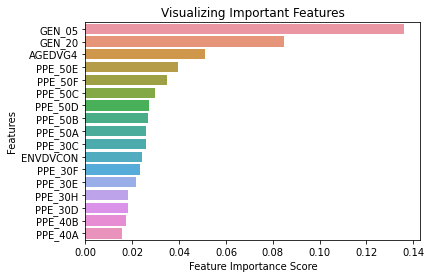

In [ ]:
#Plot top 17 features in terms of importance

feature_imp = feature_imp[:17]
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## 4A.2 Top 1 to 20 Features - Filter Method
Based on the bar graph above, it was decided to build random forest models using only the top 1 to 20 features to compare performance.

In [ ]:
#Build classification model using 1 to 20 of the top features and compare performance on Recall

recall_test = []

for n in range(1, 21):
  #Obtain names of top n variables
  top = feature_imp[:n].index

  #Split dataframe, using 80% for training and 20% for testing
  #Only select top n variables for X
  X = df.loc[:,top]
  y = df['Worse_MH']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888, stratify=y)

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  #Random forest classification model, using the parameters identified during hyperparameter tuning, except for max_features
  model = RandomForestClassifier(bootstrap='False', max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=550, random_state=888)
  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  #Save results into list
  recall_test.append(metrics.recall_score(y_test, y_pred))

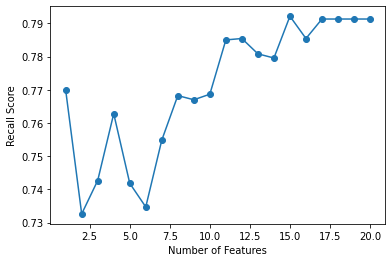

In [ ]:
#Plot recall scores against number of features used
plt.plot(range(1,21), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Features')
plt.show()

Based on the plot above, it appears that model performance is more unstable when less than 8 features are used, and then it generally increases thereafter, reaching a plateau when 15 features are used. That said, Recall only increases by 2% from using 8 features to 15 features.
*   During previous hyperparameter tuning, only the use of up 10 features was selected to test, where the best model found used 7 features. Based on the plot above, results would likely have differed if a higher number of features had been selected to test.



## 4A.3 Top 11 Features, Filter Method - Evaluation using Repeated 10-fold Cross Validation
Based on the results above, it was decided to build a random forest model using the top 11 features.

In [ ]:
#Obtain names of top 11 variables
top_eleven = feature_imp[:11].index
top_eleven

#Only select top 11 variables for X
X = df.loc[:,top_eleven]
y = df['Worse_MH']

In [ ]:
#Set cross-validation to 10-folds, repeated 3 times
folds = 10
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#Random forest classification model, using the parameters identified during hyperparameter tuning, except for max_features
model = RandomForestClassifier(bootstrap='False', max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=550, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model.fit(X_train, y_train)
  y_pred=model.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_eleven_features_filter = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.7388996290529666
Precision: 0.8335068075953681
Recall: 0.7760083522261666
F1-score: 0.8036774579611449
Area Under Curve (AUC): 0.7163900759275545
Brier Score: 0.26110037094703337
Execution time in seconds: 10.251541886133335


# 4B. 7 Selected Features using Recursive Feature Elimination (RFE) - Wrapper Method
The model obtained in section 4A.3, which used the top 11 features, did not perform as well as the base model or the tuned model in sections 1 (all features) and 3 (max features to consider at each split = 7). Thus, it was decided to try building a model using RFE with only 7 features.



In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

In [ ]:
#Random forest classification model with RFE for 7 features

#Set cross-validation to 5-folds, repeated 3 times
folds = 5
repeats = 3
rkf = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=888)

#Random forest classification model, using the parameters identified during hyperparameter tuning, except for max_features.
'''
Execution of this cell was interrupted after 6 hours, when it was still not yet finished.
Thus, to reduce computational time, n_estimators (corresponding to the number of trees) was reduced from 550 to 100.
This seemed reasonable considering that the performance of the tuned models was only slightly better than the original base model, where n_estimators=100.
The number of folds during cross-validation was also reduced from 10 to 5.
'''

model = RandomForestClassifier(bootstrap='False', max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=888)

#Performance metrics
accuracy = precision = recall = f1 = auc = brier = ex_time = 0

for train_index, test_index in rkf.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
  smote = SMOTE(random_state = 888)
  X_train, y_train = smote.fit_resample(X_train, y_train)

  t1 = time.perf_counter() #time counter start

  model = RandomForestClassifier(bootstrap='False', max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=550, random_state=888)

  #7 chosen as the number of features
  rfe = RFE(estimator=model, n_features_to_select=7) 
  rfe_fitted = rfe.fit(X_train, y_train)

  y_pred=rfe_fitted.predict(X_test)

  t2 = time.perf_counter() #time counter ends

  accuracy = accuracy + metrics.accuracy_score(y_test, y_pred)
  precision = precision + metrics.precision_score(y_test, y_pred)
  recall = recall + metrics.recall_score(y_test, y_pred)
  f1 = f1 + metrics.f1_score(y_test, y_pred)
  auc = auc + metrics.roc_auc_score(y_test, y_pred)
  brier = brier + metrics.brier_score_loss(y_test, y_pred)
  ex_time = ex_time + t2-t1

#Save results into dictionary
rf_seven_features_rfe = {'Accuracy':accuracy/(folds*repeats), 'Precision':precision/(folds*repeats),'Recall':recall/(folds*repeats),\
          'F1-Score':f1/(folds*repeats),'AUC':auc/(folds*repeats),'Brier Score':brier/(folds*repeats),'Execution Time (sec)':ex_time/(folds*repeats)}

#Evaluation of random forest classification model
print("Accuracy:", accuracy/(folds*repeats))
print("Precision:", precision/(folds*repeats))
print("Recall:", recall/(folds*repeats))
print("F1-score:", f1/(folds*repeats))
print("Area Under Curve (AUC):", auc/(folds*repeats))
print("Brier Score:", brier/(folds*repeats))
print('Execution time in seconds:', ex_time/(folds*repeats))

Accuracy: 0.7085282060165138
Precision: 0.8335406901300134
Recall: 0.7207646178807824
F1-score: 0.7730237647090923
Area Under Curve (AUC): 0.7011056449549233
Brier Score: 0.2914717939834863
Execution time in seconds: 583.1915418246672


# 5. Comparison of Models

In [ ]:
#Combine performance metrics for all models into one dataframe
comparison = pd.DataFrame([rf_all_base, rf_all_tuned, rf_eleven_features_filter, rf_seven_features_rfe], index=['RF All Features - Base','RF All Features - Tuned','RF 11 Features - Filter','RF 7 Features - RFE'])
comparison

,Accuracy,Precision,Recall,F1-Score,AUC,Brier Score,Execution Time (sec)
RF All Features - Base,0.751732,0.833188,0.799665,0.816082,0.722652,0.248268,3.000000
RF All Features - Tuned,0.756933,0.828345,0.816357,0.822251,0.720887,0.243067,21.255816
RF 11 Features - Filter,0.738900,0.833507,0.776008,0.803677,0.716390,0.261100,10.251542
RF 7 Features - RFE,0.708528,0.833541,0.720765,0.773024,0.701106,0.291472,583.191542


'RF All Features - Tuned', the random forest model using all features and the parameters identified during hyperparameter tuning, had the best Accuracy, Recall, F1-Score, and Brier Score, with a reasonable execution time of 10 seconds. It had the second best Precision and AUC, which was extremely close to the best scores achieves by the 'RF All Features - Base' model.

# 6. Stability of Best Model by Varying k-folds for Cross Validation

The stability of the best model identified above was tested by performing repeated k-folds cross-validation, with values of k from 3 to 15.

In [ ]:
X = df.drop(['Worse_MH'],axis=1)
y = df['Worse_MH']

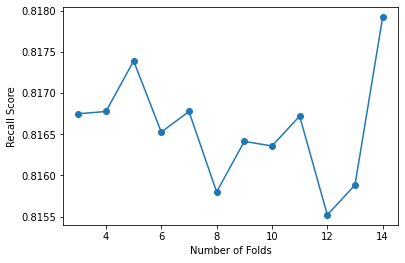

In [ ]:
recall_test = []

for k in range(3, 16):
  #Set cross-validation to k-folds, repeated 3 times
  repeats = 3
  rkf = RepeatedStratifiedKFold(n_splits=k, n_repeats=3, random_state=888)

  #Best random forest classification model identified in section 5, 'RF All Features - Tuned'
  model = RandomForestClassifier(bootstrap='False', max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=550, random_state=888)

  #Performance metrics
  recall = 0

  for train_index, test_index in rkf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Apply Synthetic Minority Oversampling Technique (SMOTE) to training set to correct class imbalance
    smote = SMOTE(random_state = 888)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)

    recall = recall + metrics.recall_score(y_test, y_pred)

  #Calculate average recall, append to list
  recall_test.append(recall/(k*repeats))

#Plot recall scores against number of features used
plt.plot(range(3, 16), recall_test, marker='o')
plt.ylabel('Recall Score')
plt.xlabel('Number of Folds')
plt.show()

print("Range of Recall Scores:", (max(recall_test)-min(recall_test))*100)

The model appears to be quite stable, with Recall ranging by less than 1%.